### Final tabular operations in preparation for adding data to web map
In this notebook we'll read back in the utah_riparian_birds.geojson and perform a few additional tabular operations that will aid in making our data look a bit nicer in the final web map. We'll also verify that our streams and occurrennces in in crs WGS84 so they play nicely with our web map.

Notebook by Zac Stanley for New Maps Plus - MAP674

#### Import python libraries

In [2]:
%matplotlib inline

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# change default figure size
plt.rcParams['figure.figsize'] = (15,12)

#### Import local datasets 

In [22]:
#utah major streams
utah_major_streams = gpd.read_file ("./data/utah_major_streams.geojson")

# utah_riparian_birds
utah_riparian_birds = gpd.read_file("./data/utah_riparian_birds.geojson")

#### Check CRS of each object

In [21]:
utah_riparian_birds.crs

{'init': 'epsg:4326'}

In [23]:
utah_major_streams.crs

{'init': 'epsg:4326'}

#### Replace month number with month name in month column

In [32]:
# 1 with January, 2 with February and so on
utah_riparian_birds['month'].replace({'1': 'January', '2': 'February','3': 'March','4': 'April','5': 'May',
'6': 'June','7': 'July','8': 'August','9': 'September','10': 'October','11': 'November','12': 'December'},
inplace=True)

#### Verify the number string were replaced with name string

In [33]:
utah_riparian_birds.sample (50)

,field_1,individual,occurrence,year,month,day,stateProvi,county,locality,decimalLat,decimalLon,scientific,vernacular,verbatimSc,geometry
534,926101,2.0,PRESENT,2019,February,17,Utah,Kane,Zion NP--East Rim Trail,37.2429,-112.873,"Baeolophus ridgwayi (Richmond, 1902)",Juniper Titmouse,Baeolophus ridgwayi,POINT (-112.87300 37.24290)
114,179085,1.0,PRESENT,2019,September,21,Utah,Washington,Confluence Park,37.2053,-113.288,"Geothlypis tolmiei (J.K.Townsend, 1839)",MacGillivray's Warbler,Geothlypis tolmiei,POINT (-113.28800 37.20530)
138,218078,4.0,PRESENT,2019,May,20,Utah,Cache,Logan Canyon--Upper,41.9431,-111.547,"Nucifraga columbiana (A.Wilson, 1811)",Clark's Nutcracker,Nucifraga columbiana,POINT (-111.54700 41.94310)
540,935081,1.0,PRESENT,2019,January,24,Utah,Utah,Diamond Fork Canyon -- Diamond Fork CG,40.0759,-111.417,"Catherpes mexicanus (Swainson, 1829)",Canyon Wren,Catherpes mexicanus,POINT (-111.41700 40.07590)
106,160029,2.0,PRESENT,2019,July,25,Colorado,Mesa,"Coates Creek School, Glade Park",38.9484,-108.976,"Pooecetes gramineus (J.F.Gmelin, 1789)",Vesper Sparrow,Pooecetes gramineus,POINT (-108.97600 38.94840)
187,303780,1.0,PRESENT,2019,April,21,Utah,Garfield,Burr Trail Rd.--Deer Creek CG,37.8547,-111.355,"Baeolophus ridgwayi (Richmond, 1902)",Juniper Titmouse,Baeolophus ridgwayi,POINT (-111.35500 37.85470)
211,334638,1.0,PRESENT,2019,May,7,Utah,Weber,"Rainbow Gardens, Ogden, Utah, US (41.236, -111...",41.2361,-111.928,"Bubo virginianus (Gmelin, 1788)",Great Horned Owl,Bubo virginianus,POINT (-111.92800 41.23610)
83,110227,1.0,PRESENT,2019,April,14,Utah,Garfield,Upper Escalante River,37.7804,-111.533,"Catherpes mexicanus (Swainson, 1829)",Canyon Wren,Catherpes mexicanus,POINT (-111.53300 37.78040)
449,758490,3.0,PRESENT,2019,March,27,Utah,Washington,"Canyon Overlook Panorama, Springdale US-UT (37...",37.2123,-112.944,"Catherpes mexicanus (Swainson, 1829)",Canyon Wren,Catherpes mexicanus,POINT (-112.94400 37.21230)
431,728107,1.0,PRESENT,2019,April,2,Utah,San Juan,Comb Wash,37.5113,-109.655,"Thryomanes bewickii (Audubon, 1827)",Bewick's Wren,Thryomanes bewickii,POINT (-109.65500 37.51130)


### Get additional attribute information for our web map
I would like to add the stream/river name from our Utah major streams to give more context to the points in the web map. To accomplish this we can buffer utah_riparian_birds to 300 ft and join them spatially with the utah_major_streams

#### Re-project points and streams again for spatial operations where distances are calculated

In [34]:
# set a variable with parameters for USA Contiguous Equidistant
project_params  = '+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'

# reproject and assign to new variables
streams_prj = utah_major_streams.to_crs(project_params)
birds_prj = utah_riparian_birds.to_crs(project_params)

#### Buffer occurrence points

In [35]:
# buffer occurrences to 300 ft as this was the distance this GeoDataFrame was originally created from
# we know the units are in meters so.......300 feet = 91.44 meters
birds_prj['buffer'] = birds_prj.buffer(91.44)

#### Inspect data

In [37]:
birds_prj['buffer'].head()

0    POLYGON ((-1548681.921 -61920.502, -1548682.36...
1    POLYGON ((-1487771.846 -59722.682, -1487772.28...
2    POLYGON ((-1517966.214 -54904.230, -1517966.65...
3    POLYGON ((-1312137.111 239794.880, -1312137.55...
4    POLYGON ((-1478483.450 -48015.680, -1478483.89...
Name: buffer, dtype: geometry

#### Make new buffered column the active geometry

In [36]:
birds_prj = birds_prj.set_geometry('buffer')

# check what column geometry is referencing
print(birds_prj.geometry.name) # buffer

buffer


#### Plot buffered occurrences and streams

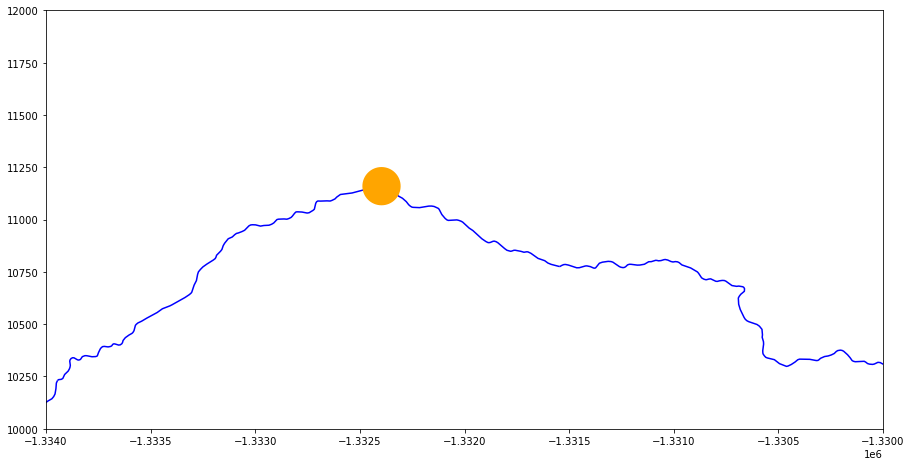

In [43]:
# verify that major streams now have buffer
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color

birds_prj.plot(ax=ax, color='orange', zorder=2, markersize=20);
streams_prj.plot(ax=ax, color='blue', zorder=1);

# modify limits to check that buffers are displayed, confirmed
ax.set(xlim=(-1334000,-1330000), ylim=(10000,12000));

#### Join spatialy streams attributes to buffered points

In [73]:
# join type argument 'how' to left to keep only existing points extratced from our previous buffer operation
birds_stream_names = gpd.sjoin(birds_prj, streams_prj, how='left', op='intersects')

In [74]:
birds_stream_names.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 598 entries, 0 to 597
Data columns (total 36 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   field_1      598 non-null    object  
 1   individual   578 non-null    object  
 2   occurrence   598 non-null    object  
 3   year         598 non-null    object  
 4   month        598 non-null    object  
 5   day          598 non-null    object  
 6   stateProvi   598 non-null    object  
 7   county       598 non-null    object  
 8   locality     598 non-null    object  
 9   decimalLat   598 non-null    float64 
 10  decimalLon   598 non-null    float64 
 11  scientific   598 non-null    object  
 12  vernacular   598 non-null    object  
 13  verbatimSc   598 non-null    object  
 14  geometry     598 non-null    geometry
 15  buffer       598 non-null    geometry
 16  index_right  0 non-null      float64 
 17  OBJECTID     0 non-null      float64 
 18  Permanent_   0 non-nul

In [79]:
birds_stream_names.drop(['OBJECTID ','Permanent_','FDate','Resolution', 'GNIS_ID','LengthKM','ReachCode', 'FlowDir',
                         'WBArea_Per','FType','FType_Text','FCode','FCode_Text','Enabled','InUtah', 'IsMajor', 'Submerged',
                         'SHAPE_Leng'], axis=1,inplace=True)

KeyError: "['OBJECTID '] not found in axis"

In [69]:
birds_stream_names = birds_stream_names.set_geometry('geometry')

# check what column geometry is referencing
print(birds_stream_names.geometry.name) # bufferbirds_prj = birds_prj.set_geometry('buffer')

geometry


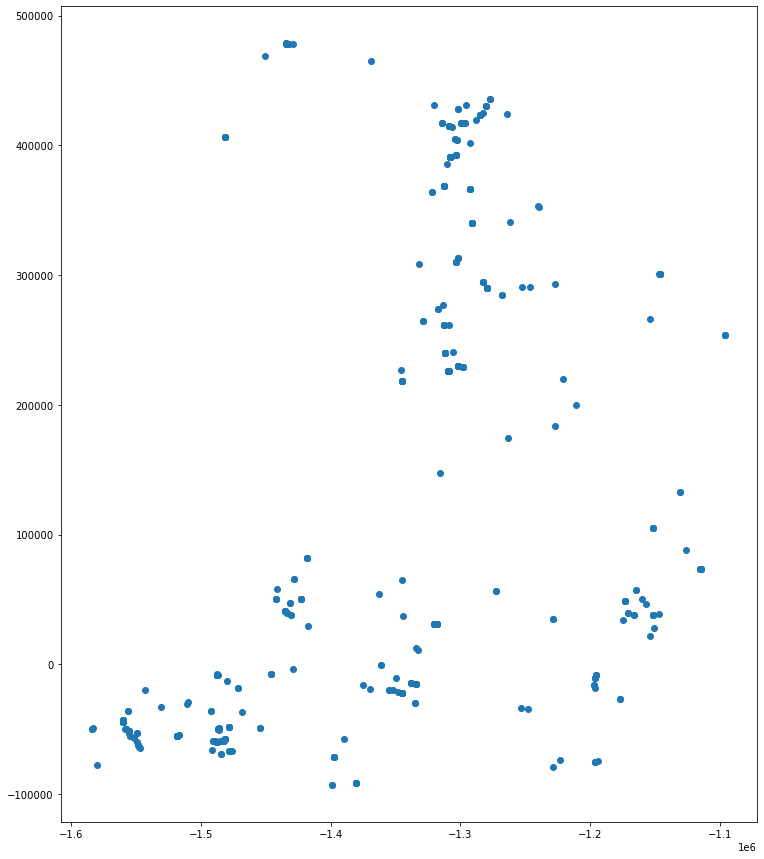

In [70]:
birds_stream_names.plot(figsize=(15,15));

In [71]:
birds_stream_names.shape

(598, 36)

In [72]:
birds_prj.shape

(598, 16)

In [78]:
birds_stream_names.to_file("./data/birds_stream_names.geojson", driver='GeoJSON')

TypeError: Cannot interpret '<geopandas.array.GeometryDtype object at 0x000001F0167F7F10>' as a data type